<br>

# Paratransit Analysis

Take home assessment exploring an excerpt of the 'Trip' table from Access-A-Ride (AAR) Paratransit's scheduling engine.

**Table of Contents**
1. Environment - loading Python libraries and 'trips.csv'
2. Data Quality Visualization
    - summary of trips data
    - visualizations to explore the extent of missing data
3. Questions
    * Question 1: summaries by ProviderType for weekend vs weekday
        1. total number of successful trips
        2. average trips per day
        3. % trips by mode
    * Question 2: top 10 zipcodes for AM rush hour Primary trip pickups
    * Question 3: flexible B-leg assessment comparing intra and inter ZIP trip distances
        1. Intra-borough trips
        2. Inter-borough trips
        3. Total
        4. Summary
4. Summary

## 1) Environment

Setting up the environment for our analysis.
Recommended use: create a virtual environment to run and install package dependencies from requirements.txt
   * **pip** python3 -m pip install -r requirements.txt
   * **conda** conda create --name <env_name> --file requirements.txt
   
   
The following code will:
1. load necessary Python libraries
2. load "trips.csv" as a pandas DataFrame
    - **Note** this notebook assumes "trips.csv" exists in the same working directory

In [1]:
# 1.1 loading necessary Python libraries
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import session_info
import numpy as np
session_info.show()

In [2]:
# 1.2 loading "trips.csv" as a pandas DataFrame
# NOTE: this code assumes that 'trips.csv' exists in the same directory as this notebook.
df = pd.read_csv('trips.csv')
# display basic information about the dimensions and features of df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1164013 entries, 0 to 1164012
Data columns (total 18 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   TripId        1164013 non-null  int64  
 1   Clientid      1164013 non-null  int64  
 2   Status        1164013 non-null  object 
 3   ProviderType  1164013 non-null  object 
 4   Outcome       1164013 non-null  object 
 5   Tripdate      1164013 non-null  object 
 6   RequestTime   1164013 non-null  object 
 7   PromiseTime   1164013 non-null  object 
 8   ProviderId    543476 non-null   object 
 9   APtime        1164012 non-null  object 
 10  APtime1       1164013 non-null  object 
 11  ADtime        1164012 non-null  object 
 12  Anchor        1164013 non-null  object 
 13  PickCounty    1138339 non-null  object 
 14  PickZip       1138336 non-null  object 
 15  DropCounty    1138338 non-null  object 
 16  DropZip       1138336 non-null  object 
 17  TripMiles     1164013 non-n

<br>

## 2) Data Quality Visualization

<br>

From the output of the .info() method above, we can see that not all of the data features are free of null values (see 'Non-Null Count'). To gain a further understanding of the data, we can visualize the missing values (missingness) of the data quickly with the `missingno` Python library  

The `missingno` library has been imported as `msno`. Here we will use both the matrix and bar visualizations to evaluate the data

<AxesSubplot:>

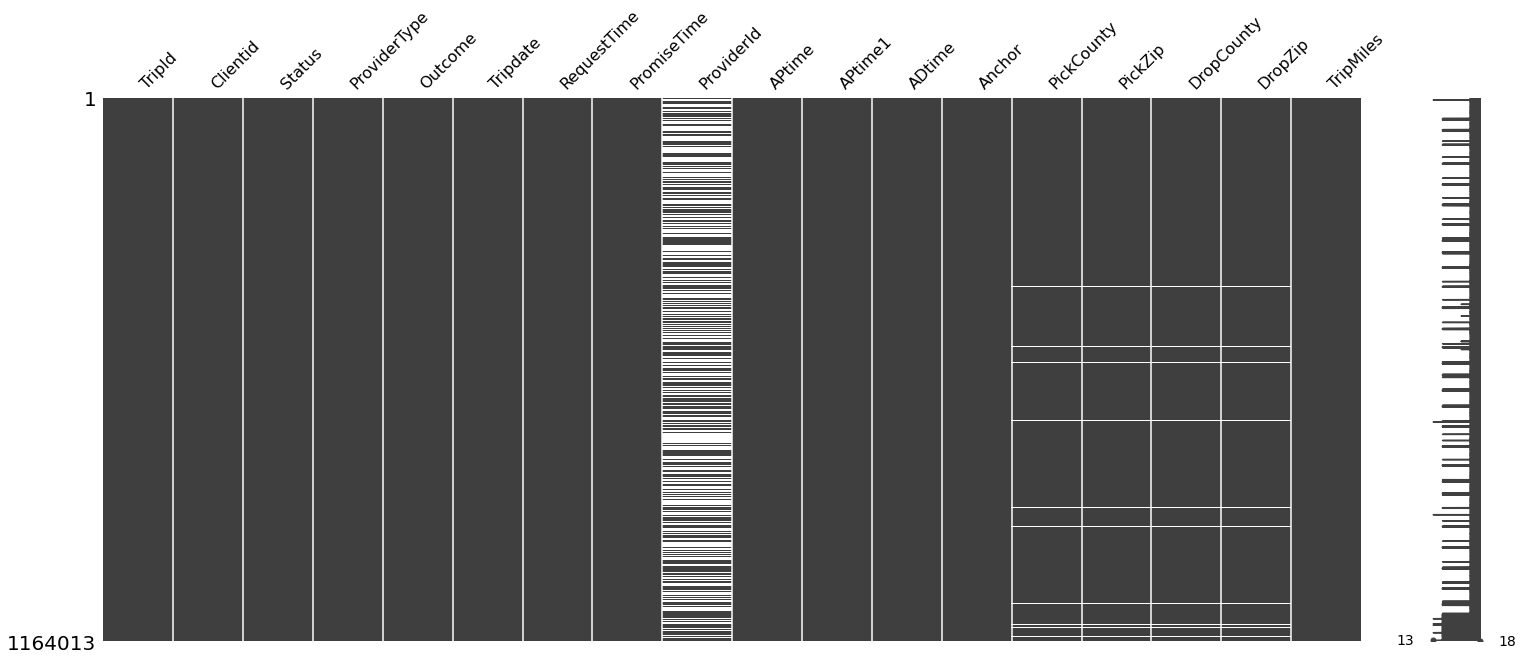

In [3]:
# matrix style visualization of trips data
msno.matrix(df)

<AxesSubplot:>

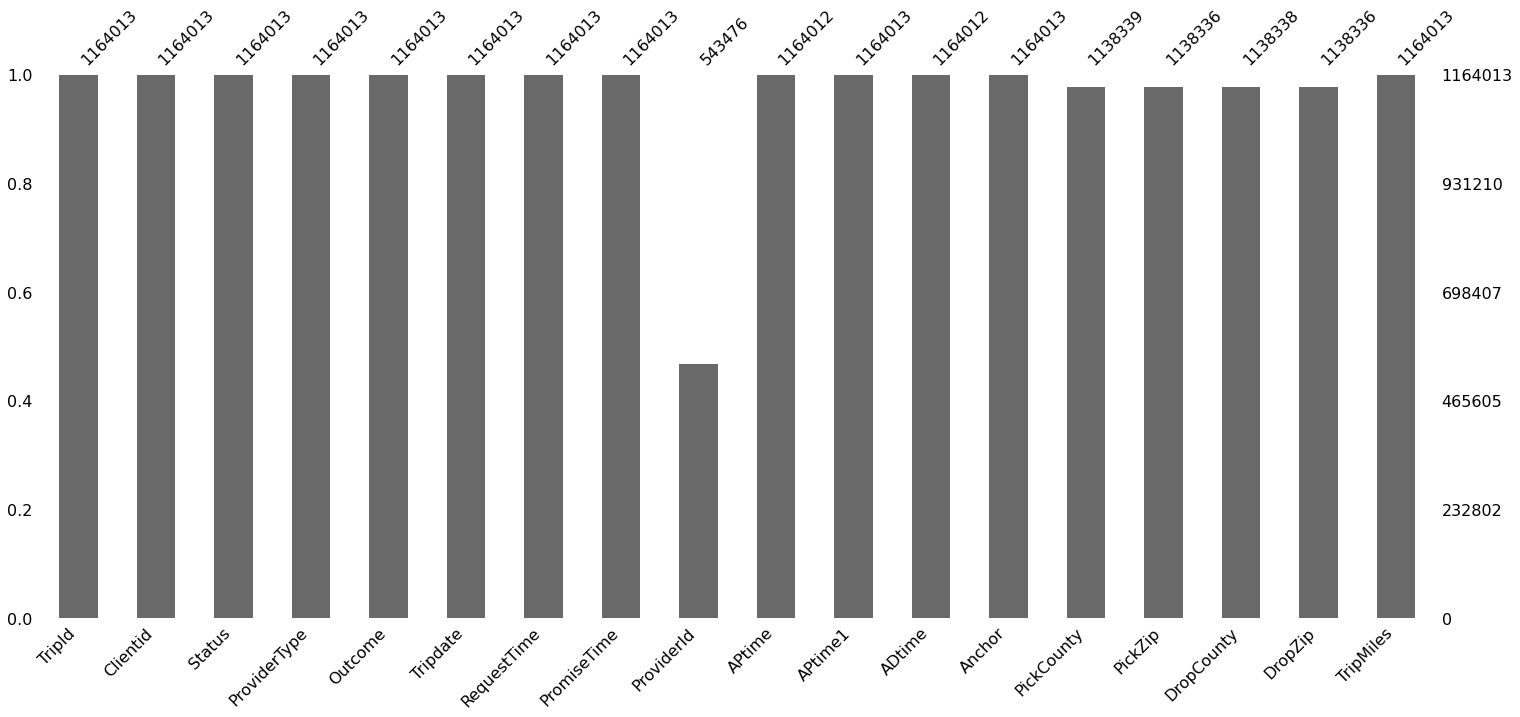

In [4]:
# bar style visualization of trips data
msno.bar(df)

From the above visualizations it is readily apparent that the `ProviderID` feature is missing values for more than half of the records. The columns `APtime`, `ADtime`, `PickCounty`, `PickZip`, `DropCounty` and `DropZip` are missing comparatively fewer data values. For analyses that use features with missing data, we will have to strategize a way to deal with null values.  

Detailed looks at the features directly used in the analysis will be taken up in the following sections

<br>  

## 3) Questions

### Question 1: proportion of trips completed on "primary" vs "broker" or "e-hail" trips.

Provide a table showing the following for the three provider types of interest (primary, broker & e-hail) comparing weekday vs weekend:
1. total number of successful trips
2. average trips per day
3. % trips by mode

#### Approach for Question 1.1: total number of successful trips

1. Preliminary Data Shaping: 
    - evaluate the `ProviderType` feature
    - subset the trips df to just the variables (columns) needed
    - create a new data feature to indicate if the trip occured on a weekday or weekend.
    - the resulting data structure will be used for each of the three tasks for Question 1
2. Total Number of Successful Trips
    - evaluate `Outcome` feature
    - subset on the relevant ('successful') Outcome criteria
    - render a table with the pandas .crosstab() method
    
start by evaluating `ProviderType`:

In [5]:
# use the .value_counts() pandas method to show a quick table of the unique values of ProviderTypes
df.ProviderType.value_counts()

E-Hail                 642331
Broker                 293832
Primary                152762
Deleted                 41964
Driver break record     25669
Fixed Route-Exclude      7351
Test Record               104
Name: ProviderType, dtype: int64

Based on the instructions, we are only interested in the outcomes for 'Primary','Broker', and 'E-Hail' trips.  
Next, we limit the scope of the analysis to only the variables (columns) needed for the analysis and only the records with just the types of providers we are interested in:

In [6]:
# subset to just the relevant variables (columns): 'ProviderType' 'Outcome' & 'Tripdate'
Q1_cols = ['ProviderType', 'Outcome', 'Tripdate']
df_PType_PBE = df[Q1_cols].copy()

In [7]:
# subset trips to records with ProviderType == 'Primary','Broker', or 'E-Hail'
ptypes = ['Primary','Broker','E-Hail']
df_PType_PBE = df_PType_PBE[df_PType_PBE['ProviderType'].isin(ptypes)]
df_PType_PBE.ProviderType.value_counts()

E-Hail     642331
Broker     293832
Primary    152762
Name: ProviderType, dtype: int64

We would like to compare weekday vs weekend trips. This will be facilitated by creating a new variable (column) indicating whether a given trip occured on a weekend or weekday.

In [8]:
# add a new data feature (variable) to indicate of the trip occured on a weekday or weekend.
df_PType_PBE["Tripdate"] = pd.to_datetime(df_PType_PBE["Tripdate"])
df_PType_PBE["IsWeekend"] = df_PType_PBE["Tripdate"].dt.weekday >= 5
df_PType_PBE["IsWeekend"] = ['Weekend' if t else 'Weekday' for t in df_PType_PBE["IsWeekend"]]

# display the first 5 records
df_PType_PBE.head()

,ProviderType,Outcome,Tripdate,IsWeekend
0,E-Hail,Early Cancel,2022-04-01,Weekday
1,E-Hail,Authorized,2022-04-01,Weekday
2,E-Hail,Early Cancel,2022-04-01,Weekday
3,E-Hail,Early Cancel,2022-04-01,Weekday
4,Primary,Completed,2022-04-01,Weekday


The dataframe `df_PType_PBE` will serve as a starting point to produce the deliverables of each task for Questions 1.  

The following code will further process the data to produce a table showing the total number of successful trips

In [9]:
# evaluate the 'Outcomes' feature
df_PType_PBE.Outcome.value_counts()

Authorized            392457
Customer Refusal      327400
Early Cancel          164502
Completed             139659
Late Cancel            46553
Customer no-show       17204
No-fault no-show         835
Provider no-show         308
Other FLTR_Outcome         4
Denial                     3
Name: Outcome, dtype: int64

From the output above, we see that there are many different Outcomes for Access-A-Ride trips. However, for this task we are only concerned with the 'successful' trips.  
Successful trips meet the following criteria:
* ProviderType == 'Primary' AND Outcome == 'Completed'
* ProviderType == 'Broker' AND Outcome == 'Authorized'
* ProviderType == 'E-Hail' AND Outcome == 'Authorized'

Therefore, we will take the subset of df_PType_PBE records that meet these criteria

In [10]:
# subset on the relevant ('successful') Outcome criteria
p_sub = df_PType_PBE.query('ProviderType  == "Primary" & Outcome == "Completed"') # successful Primary trips
b_sub = df_PType_PBE.query('ProviderType  == "Broker" & Outcome == "Authorized"') # successful Broker trips
e_sub = df_PType_PBE.query('ProviderType  == "E-Hail" & Outcome == "Authorized"') # successful E-Haul trips
# concatenate the results into a single dataframe
success_df = pd.concat([p_sub, b_sub, e_sub])
success_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 532116 entries, 4 to 1164008
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   ProviderType  532116 non-null  object        
 1   Outcome       532116 non-null  object        
 2   Tripdate      532116 non-null  datetime64[ns]
 3   IsWeekend     532116 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 20.3+ MB


In [11]:
# use the .crosstab method to visualize a table of the total number of successful trips
# for the each of the three provider types and compare weekend vs weekday
pd.crosstab(success_df.IsWeekend, success_df.ProviderType, margins=True, margins_name="Total")

ProviderType,Broker,E-Hail,Primary,Total
IsWeekend,,,,
Weekday,230605,86357,112506,429468
Weekend,58012,17483,27153,102648
Total,288617,103840,139659,532116


The table above shows the total number of successful trips for the Broker, E-Hail and Primary trips and compares the number of rides on weekdays with weekend.

<br>

#### Approach for Question 1.2: average trips per day

1. Average trips per day
    - start with the df_PType_PBE dataframe
    - group the trips by date and ProviderType and count the occurances
    - group the result by IsWeekend and ProviderType and find the mean values
    - render a table by pivoting the result 
    
start by grouping trips to count by day of trip and provider type:

In [12]:
# group the trips by date and ProviderType and count the occurances
perday_df = df_PType_PBE.groupby(['Tripdate', 'ProviderType', 'IsWeekend']) \
    ['Outcome'].count().reset_index(name="count")
# display the first 5 rows of the reshaped data
perday_df.head()

,Tripdate,ProviderType,IsWeekend,count
0,2022-04-01,Broker,Weekday,11202
1,2022-04-01,E-Hail,Weekday,24939
2,2022-04-01,Primary,Weekday,5895
3,2022-04-02,Broker,Weekend,6961
4,2022-04-02,E-Hail,Weekend,14337


The data structure above holds a record for each Tripdate for each ProviderType whether this day is a weekday/end and the number of occurences. We will now use one more groupby to transform the data into the result we would like: the average number of trips per day for each Provider type for both weekends and weekdays:

In [13]:
perday_df = perday_df.groupby(['ProviderType', 'IsWeekend']) \
    ['count'].mean().reset_index(name="average")
perday_df

,ProviderType,IsWeekend,average
0,Broker,Weekday,11175.190476
1,Broker,Weekend,6572.555556
2,E-Hail,Weekday,24427.904762
3,E-Hail,Weekend,14371.666667
4,Primary,Weekday,5845.095238
5,Primary,Weekend,3335.000000


The output above holds the values we are interested in. However, if we do some light reformatting by pivoting the dataframe, we can achieve a more aesthetic output:

In [14]:
# pivot the data on ProviderType and maintain IsWeekend as index
perday_df = perday_df.pivot(index='IsWeekend',columns='ProviderType')
perday_df.style

#### Approach for Question 1.3: % trips by mode

1. % trips by mode
    - start with the df_PType_PBE dataframe
    - use .crosstab() methods to produce table summary
    
Manipulating the data for this task is quite simple, because we just need to crosstabulate the 'df_PType_PBE' dataframe and normalize the score to find the joint probabilities:

In [15]:
# form crosstab with dropna=True (default)
percent_res = pd.crosstab(df_PType_PBE.IsWeekend, df_PType_PBE.ProviderType,
            margins=True, margins_name="Total", normalize=True)*100
percent_res

ProviderType,Broker,E-Hail,Primary,Total
IsWeekend,,,,
Weekday,21.551438,47.109397,11.272310,79.933145
Weekend,5.432238,11.878229,2.756388,20.066855
Total,26.983677,58.987625,14.028698,100.000000


The tabel above gives the joint probabilities. For example, the joint probability that a trip is made by an E-Haul provider on a weekday is 47%. However, if we are more interested in the conditional probability that a ride provider was E-Haul, given that it was on a weekday, we can make the following transformation of the data:

In [16]:
cond_res = percent_res.div(percent_res['Total'].values,axis=0)*100
cond_res

ProviderType,Broker,E-Hail,Primary,Total
IsWeekend,,,,
Weekday,26.961830,58.935998,14.102172,100.0
Weekend,27.070701,59.193275,13.736025,100.0
Total,26.983677,58.987625,14.028698,100.0


<br>

### Question 2: Top 10 Zipcodes

* provide a list of the top 10 ZIP codes where successful Primary trip pickups occur during the AM rush hour (06:00 through 10:00).
* include count/total for each zipcode
* use a time feature that is 'future looking' (when customers were scheduled to be picked up)

#### Approach for Question 2

Overview of analysis process:

1. Preliminary Data Shaping
    - subset the data to just the relevant features for this portion of the analysis:
        - 'ProviderType', 'Outcome' :: these will be used to filter successful Primary trips
        - 'PromiseTime' :: will be used as the 'future looking' trip pickup time
        - 'PickZip' :: map result to the customer's origin zipcode
        - drop records with null values from dataset
    - filter for 'successful' Primary trips
        - 'ProviderType  == "Primary" & Outcome == "Completed"'
    - filter for the AM rush
        - is 'PromiseTime' within the hours of 6am $\rightarrow$ 10am?
2. Top Zipcodes
    - group by 'PickZip' and count the records
    - sort by count result
    - return the top 10 records and corresponding counts

In [17]:
# subset relevant columns of trips data
zipcodes_df = df[['ProviderType', 'Outcome', 'PromiseTime', 'PickZip']]
zipcodes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1164013 entries, 0 to 1164012
Data columns (total 4 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   ProviderType  1164013 non-null  object
 1   Outcome       1164013 non-null  object
 2   PromiseTime   1164013 non-null  object
 3   PickZip       1138336 non-null  object
dtypes: object(4)
memory usage: 35.5+ MB


Here is where using the `missingno` library comes in handy: we are already aware that the 'PickZip' variable holds some null values. The following code will drop records with missing information:

In [18]:
zipcodes_df = zipcodes_df.dropna()
zipcodes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1138336 entries, 0 to 1164012
Data columns (total 4 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   ProviderType  1138336 non-null  object
 1   Outcome       1138336 non-null  object
 2   PromiseTime   1138336 non-null  object
 3   PickZip       1138336 non-null  object
dtypes: object(4)
memory usage: 43.4+ MB


Next, we will find the records that correspond to 'successful' primary provider trips which occured during the morning rush hours:

In [19]:
# filter for 'successful' Primary trips
zipcodes_df = zipcodes_df.query('ProviderType  == "Primary" & Outcome == "Completed"') # successful Primary trips
zipcodes_df.shape

(139658, 4)

In [20]:
# filter for the AM rush
# parse the hour the PromiseTime occured
zipcodes_df["tripHour"] = [int(h.split(':')[0]) for h in zipcodes_df['PromiseTime']]
# filter the records whose tripHour is between [6,10)
zipcodes_df = zipcodes_df[zipcodes_df['tripHour'].between(6, 10, inclusive='left')]

# display the first 5 records
print( zipcodes_df.shape )
zipcodes_df.head()

(37456, 5)


,ProviderType,Outcome,PromiseTime,PickZip,tripHour
4,Primary,Completed,09:30,11203,9
8,Primary,Completed,07:15,11221,7
9,Primary,Completed,09:45,11429,9
11,Primary,Completed,07:30,11236,7
24,Primary,Completed,07:30,10306,7


Now that we have filtered the relevant information, we can group by zipcode and find the zipcodes with the most records:

In [21]:
count_name = "Number of Primary Trips during AM Rush Hour"
zipcodes_count = zipcodes_df.groupby(['PickZip'])['tripHour'] \
    .count().reset_index(name=count_name) \
    .sort_values(by=count_name, ascending=False)

In [22]:
zipcodes_count.head(10).style

,PickZip,Number of Primary Trips during AM Rush Hour
65,10314,1177
133,11212,869
55,10304,857
128,11207,823
52,10301,768
57,10306,753
219,11434,710
161,11233,637
230,11691,611
166,11236,600


<br>

### Question 3: Cost Forcasting for a 'Flexible B-leg'

For trips beginning or ending in 11201, 10469, 11694, 10306:
* Intra-borough trips (started and ended in one of the four zip codes)
    * mean trip distance
    * total number of trips
* Inter-borough trips (started/ended in 11201, 10469, 11694, 10306 and ended/started in Manhattan)
    * mean trip distance
    * total number of trips
* Overall trips
    * mean of intra & inter trips distances
    * total number of inter and intra trips

#### Approach for Question 3

Overview of analysis process:

* Data Preparation
    - subset on the columns used for this analysis: 'PickZip', 'DropZip', 'PickCounty', 'DropCounty', 'TripMiles'
    - select all trips that either started or ended in one of the following zipcodes: 11201, 10469, 11694, 10306
* Intra-Borough trips
    - find records where 'PickZip'=='DropZip'
    - groupby zipcode count records and find mean TripMiles
    - add a new field, 'target_zip' which identifies which zipcode of interest the trip took place in (to be used in later steps)
* Inter-Borough trips
    - find records where PickCounty='New York' & DropZip is a target zipcode
    - find records where PickZip is a target zipcode & DropCounty = 'New York'
    - to each of these results, add a new field 'target_zip' which identifies which zipcode of interest the trip either originated from or concluded in.
    - combine the two dataframes, groupby 'target_zip' and aggregate to find the number of records and mean TripMiles
* Total (all trips starting or ending in ZIP)
    - combine the dataframes for intra & inter borough trips
    - group the results by the field 'target_zip', aggregate to find the total number of observations and mean TripMiles for each of the four target zipcodes
* Presenting the results
    - combine the summary results for intra, inter and total
    - format as an easily readable table

**Data Preparation**

We are interested in the pick-up and drop-off locations (both zip code and county) as well as the distance of the trip. Let's start by selecting the data relevant for this analysis:

In [23]:
# subset on columns used for analysis
zip_cols = ['PickZip', 'DropZip', 'PickCounty', 'DropCounty', 'TripMiles']
flexB_df = df[zip_cols]

# select trips that either started or ended in the target zipcodes
zips = ['11201', '10469', '11694', '10306']
flexB_df = flexB_df.query('PickZip.isin(@zips) | DropZip.isin(@zips)')
flexB_df.shape

(74134, 5)

**Intra-Borough trips**

Find the records where the pick-up and drop-off zipcodes are the same (one of the four target zips). Then, perform a simple aggregation over the result to find the number of trips as well as the mean distance travelled.

In [24]:
# find records where 'PickZip'=='DropZip'
intraB_df = flexB_df.query('PickZip == DropZip').copy()
# create a new feature that identifies the which one of the four target zip codes this trip involves
# this will come in handy when we need to summarize the total trips
intraB_df['target_zip'] = intraB_df['PickZip']
# groupby zipcode count records and find mean TripMiles
intra_b_res = intraB_df.groupby(['PickZip']) \
       .agg({'DropZip':'size', 'TripMiles':'mean'}) \
       .rename(columns={'DropZip':'count','TripMiles':'mean distance'})
intra_b_res

,count,mean distance
PickZip,,
10306,1209,0.595095
10469,613,0.403377
11201,696,0.203233
11694,105,0.298762


**Inter-Borough trips**

to be interpreted as trips either:
* from Manhattan to a target zipcode
* from a target zipcode to Manhattan

To find the inter-borough trips, we will create two data subsets for trips from Manhattan to a target zipcode and for trips from a target zipcode to Manhattan. As we create a 'target_zip' variable in the same way we did for intra-borough data. However, here the feature will be directly useful, because we can use it to group the data and produce the desired summary metrics:

In [25]:
# from Manhattan to target zip
fromM_df = flexB_df.query('PickCounty=="New York" & DropZip.isin(@zips)').copy()
fromM_df['target_zip'] = fromM_df['DropZip']

# from target zip to Manhattan
toM_df = flexB_df.query('DropCounty=="New York" & PickZip.isin(@zips)').copy()
toM_df['target_zip'] = toM_df['PickZip']

# concatenate the results
interB_df = pd.concat([fromM_df, toM_df])

# groupby target zipcode, count records, and find mean TripMiles
inter_b_res = interB_df.groupby(['target_zip']) \
       .agg({'DropZip':'size', 'TripMiles':'mean'}) \
       .rename(columns={'DropZip':'count','TripMiles':'mean distance'})
inter_b_res

,count,mean distance
target_zip,,
10306,1381,10.443454
10469,4055,5.781354
11201,4264,2.984306
11694,657,8.717610


**Totals (all trips starting or ending in ZIP)**

We have already done most of the work. Now we just need to combine the intra and inter borough results:
* concatenate intraB_df and interB_df
* groupby 'target_zip', counts records, and find the mean TripMiles

In [26]:
# concatenate the previous results
total_df = pd.concat([intraB_df, interB_df])
# groupby target zipcode, count records, and find mean TripMiles
total_res = total_df.groupby(['target_zip']) \
       .agg({'DropZip':'size', 'TripMiles':'mean'}) \
       .rename(columns={'DropZip':'count','TripMiles':'mean distance'})
total_res

,count,mean distance
target_zip,,
10306,2590,5.846286
10469,4668,5.075120
11201,4960,2.594058
11694,762,7.557533


**Summary Table**  

Let's consolidate the output into a clear and concise table:

In [27]:
combined_results = pd.concat([intra_b_res, inter_b_res, total_res], axis=1)
midx = pd.MultiIndex.from_product([['Intra-borough trips', 'Inter-borough trips', 'Totals (all trips starting or ending in ZIP)'],
                            ['Total trips','Mean distance']], names=['Subset:', 'Measure:'])
combined_results.columns = midx
combined_results

Subset:  Intra-borough trips               Inter-borough trips                \
Measure:         Total trips Mean distance         Total trips Mean distance   
10306                   1209      0.595095                1381     10.443454   
10469                    613      0.403377                4055      5.781354   
11201                    696      0.203233                4264      2.984306   
11694                    105      0.298762                 657      8.717610   

Subset:  Totals (all trips starting or ending in ZIP)                
Measure:                                  Total trips Mean distance  
10306                                            2590      5.846286  
10469                                            4668      5.075120  
11201                                            4960      2.594058  
11694                                             762      7.557533

From the table above, we can see that the Mean Distance for Inter-borough trips for each zip code is an order of magnitude greater than the Mean Distance for Intra-borough trips. To underscore this, we can visualize the trip distance distributions for intra- and inter-borough trips (successful primary provider trips)

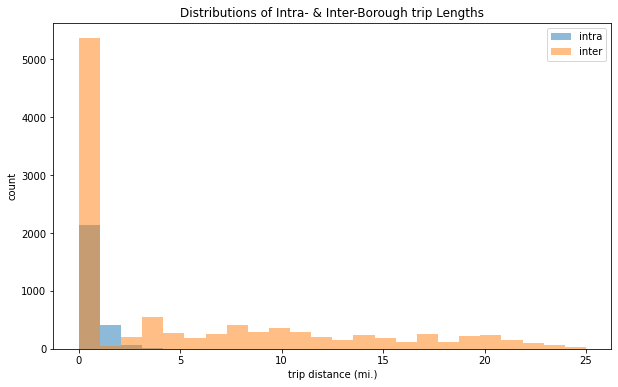

In [28]:
x = intraB_df.TripMiles.tolist()
y = interB_df.TripMiles.tolist()

bins = np.linspace(0, 25, 25)

plt.figure(figsize=(10,6))
plt.hist(x, bins, alpha=0.5, label='intra')
plt.hist(y, bins, alpha=0.5, label='inter')
plt.title('Distributions of Intra- & Inter-Borough trip Lengths')
plt.legend(loc='upper right')
plt.xlabel('trip distance (mi.)')
plt.ylabel('count')
plt.show()

The orange series in the figure above shows the distribution of inter-borough trip distances. We can readily see that this data is much longer tailed (has more higher values) than the intra-borough trips given in blue. Therefore, because trip  cost scales with trip distance scales it follows that inter-borough trips are generally more costly to the MTA. However, it would be interesting to compare these results with the numerosity and mean distance traveled for inter-borough trips that do not involve Manhattan

<br><br>

***

<br><br>

### Background Notes

**Access-A-Ride** a paratransit service that provides public transportation for eligible customers who have disabilities that prevent the from using the public buses and subways
- 5 boroughs + a 3/4 mile corridor beyond fixed-route service
- shared-ride program
- Origin to destination service or feeder service
- Non-priority trips with maximum ride times based on distance
- 24/7 * 365
- compliance with ADA regulations
    
Three modes to provide service:
1. 'Primary' carrier - Access-A-Ride vans
2. 'Broker' service from taxi companies
3. 'E-hail' rides dispatched through Lift, Arro, Curb etc.

Customer can specify either:
* Pickup - when they would like to be picked up
* Appointment - when they would like to arrive at thier destination

Primary trips are considered successful if Outcome == 'Completed'  
Other services are considered successful if Outcome == 'Authorized'

<br><br>